<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#&quot;Implémentez-un-modèle-de-scoring&quot;" data-toc-modified-id="&quot;Implémentez-un-modèle-de-scoring&quot;-1">"Implémentez un modèle de scoring"</a></span><ul class="toc-item"><li><span><a href="#0-Preliminaries" data-toc-modified-id="0-Preliminaries-1.1">0 Preliminaries</a></span><ul class="toc-item"><li><span><a href="#0.0-Importing-Packages-and-Modules" data-toc-modified-id="0.0-Importing-Packages-and-Modules-1.1.1">0.0 Importing Packages and Modules</a></span></li><li><span><a href="#0.1-Importing-data-and-model" data-toc-modified-id="0.1-Importing-data-and-model-1.1.2">0.1 Importing data and model</a></span></li></ul></li><li><span><a href="#1-Customer's-choice" data-toc-modified-id="1-Customer's-choice-1.2">1 Customer's choice</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Nearest-Neighbors" data-toc-modified-id="Nearest-Neighbors-1.2.0.1">Nearest Neighbors</a></span></li></ul></li></ul></li><li><span><a href="#2-Data-Visualization-after-preprocessing-(2D-projection)" data-toc-modified-id="2-Data-Visualization-after-preprocessing-(2D-projection)-1.3">2 Data Visualization after preprocessing (2D projection)</a></span></li><li><span><a href="#Model-and-dashboard-deployment" data-toc-modified-id="Model-and-dashboard-deployment-1.4">Model and dashboard deployment</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Prepare-the-MLFlow-model-from-our-best-model" data-toc-modified-id="Prepare-the-MLFlow-model-from-our-best-model-1.4.0.1">Prepare the MLFlow model from our best model</a></span></li><li><span><a href="#Deploy-model-on-local-server" data-toc-modified-id="Deploy-model-on-local-server-1.4.0.2">Deploy model on local server</a></span></li><li><span><a href="#Run-the-dashboard-(that-will-request-prediction-from-the-model)" data-toc-modified-id="Run-the-dashboard-(that-will-request-prediction-from-the-model)-1.4.0.3">Run the dashboard (that will request prediction from the model)</a></span></li><li><span><a href="#Deploy-the-streamlit-dashboard-???" data-toc-modified-id="Deploy-the-streamlit-dashboard-???-1.4.0.4">Deploy the streamlit dashboard ???</a></span></li></ul></li></ul></li></ul></li></ul></div>

# "Implémentez un modèle de scoring"
_Building and optimizing a classification model_

References used for this notebook:


## 0 Preliminaries

### 0.0 Importing Packages and Modules

In [1]:
import io
import random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.facecolor']='w'

In [2]:
from P7_functions import *

In [3]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
    pd.set_option(k,v)

### 0.1 Importing data and model

In [4]:
# import cleaned data and model

import dill

with open('..\\PICKLES\\dict_cleaned.pkl', 'rb') as file:
    dict_cleaned = dill.load(file)
with open('..\\PICKLES\\P7_04_bestmodel_thesh.pkl', 'rb') as file:
    best_model, thresh = dill.load(file)
# with open('..\\PICKLES\\P7_04_bestmodel_thesh.pkl', 'rb') as file:
#     best_model, thresh = dill.load(file)

In [5]:
# put data from dictionary into variables
X_train = dict_cleaned['X_train']
y_train = dict_cleaned['y_train']
X_test = dict_cleaned['X_test']

In [6]:
# split the steps of the best pipeline
preproc_step = best_model.named_steps['preproc']
featsel_step = best_model.named_steps['featsel']
clf_step = best_model.named_steps['clf']

# compute the preprocessed data (encoding and standardization)
X_tr_prepro = preproc_step.transform(X_train)
X_te_prepro = preproc_step.transform(X_test)

# get the name of the columns after encoding
preproc_cols = X_tr_prepro.columns

# get the name of the columns selected using SelectFromModel
featsel_cols = preproc_cols[featsel_step.get_support()]

# compute the data to be used by the best classifier
X_tr_featsel = X_tr_prepro[featsel_cols]
X_te_featsel = X_te_prepro[featsel_cols]

## 1 Customer's choice

In [7]:
# random sample of customers

N =5000
random_samp = X_train.sample(N).index

In [8]:
# select one customer among the sample

X_cust = X_train.loc[random_samp].sample(1)
customer_idx = X_cust.index.values[0]

In [9]:
X_tr_featsel.loc[customer_idx: customer_idx].shape, X_tr_featsel.shape

((1, 41), (307511, 41))

#### Nearest Neighbors

In [10]:
# get indices of the 20 nearest neighbors in the X_tr dataframe 

from sklearn.neighbors import NearestNeighbors

# fit nearest neighbors among the selection

neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(X_tr_featsel.loc[random_samp])

idx = neigh.kneighbors(X=X_tr_featsel.loc[customer_idx: customer_idx],
                       n_neighbors=20,
                       return_distance=False).ravel()

nearest_cust_idx = list(X_tr_featsel.loc[random_samp].iloc[idx].index)

## 2 Data Visualization after preprocessing (2D projection)

In [11]:
# Computes the axes for projection with centers

dict_proj, dict_proj_centers, _ = prepare_2D_axes(X_tr_featsel.loc[random_samp],
                                                  y_train.loc[random_samp],
                                                  ser_clust=y_train.loc[random_samp],
                                                  proj=['t-SNE'],
                                                  model=None,
                                                  centers_on=True,
                                                  random_state=14)

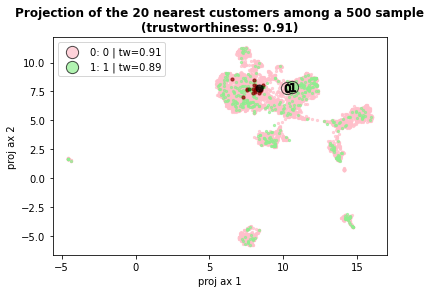

In [12]:
# Projection of a sample of the training set, colored with target value

fig, ax = plt.subplots()

proj = 'UMAP'

# show random sample
plot_projection(X=X_tr_featsel.loc[random_samp],
                y=y_train.loc[random_samp],
                model=None,
                plot_only_idx = random_samp,
                dict_proj = dict_proj,
                dict_proj_centers = dict_proj_centers,
                ser_clust = y_train.loc[random_samp],
                proj=proj, # PCA, UMAP, t-SNE
                tw_n_neigh=5, title="Projection of the 20 nearest customers among a 500 sample",
                bboxtoanchor=None, figsize=(10, 6), size=5, palette=['pink','lightgreen'],
                show_centers=True, legend_on=True, fig=fig, ax=ax, random_state=14)

# show nearest neighbors
plot_projection(X=X_tr_featsel.loc[random_samp],
                y=y_train.loc[random_samp],
                model=None,
                plot_only_idx = nearest_cust_idx,
                dict_proj = dict_proj,
                dict_proj_centers = dict_proj_centers,
                ser_clust = y_train.loc[random_samp],
                proj=proj, # PCA, UMAP, t-SNE
                tw_n_neigh=None, title=None,
                bboxtoanchor=None, figsize=(10, 6), size=10, palette=['darkred','darkgreen'],
                show_centers=False, legend_on=True, fig=fig, ax=ax, random_state=14)

# show nearest neighbors
plot_projection(X=X_tr_featsel.loc[random_samp],
                y=y_train.loc[random_samp],
                model=None,
                plot_only_idx = [customer_idx],
                dict_proj = dict_proj,
                dict_proj_centers = dict_proj_centers,
                ser_clust = y_train.loc[random_samp],
                proj=proj, # PCA, UMAP, t-SNE
                tw_n_neigh=None, title=None,
                bboxtoanchor=None, figsize=(10, 6), size=50, palette=['k'],
                show_centers=False, legend_on=True, fig=fig, ax=ax, random_state=14)

## Model and dashboard deployment

In [13]:
import streamlit as st
import numpy as np
import pandas as pd
import dill

#### Prepare the MLFlow model from our best model

In [14]:
#  create a signature from the model input data 

from mlflow.models.signature import infer_signature
signature = infer_signature(X_train, y_train)

In [26]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit(X_tr_featsel.loc[random_samp], y_train.loc[random_samp])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LogisticRegression()

In [28]:
# save the best pipeline

signature2 = infer_signature(X_tr_featsel.loc[random_samp], y_train.loc[random_samp])
mlflow.sklearn.save_model(lg, 'mlflow_lg', signature=signature2)

In [23]:
# save the best pipeline

import mlflow.sklearn
mlflow.sklearn.save_model(best_model, 'mlflow_bestmodel', signature=signature)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


MlflowException: Path 'mlflow_bestmodel' already exists

In [21]:
# export the best threshold in a .txt
f = open(r"thresh.txt", "w+")
f.write(str(thresh))
f.close()

# # retrieve the threshold stored in a text file
# f = open(r"thresh.txt", "r")
# thresh_retrieved = f.read()
# f.close()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Deploy model on local server

#### Run the dashboard (that will request prediction from the model)

#### Deploy the streamlit dashboard ???